In [9]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt
import time
import os

#### CIFAR-100数据集图像的均值和方差

In [5]:
CIFAR100_TRAIN_MEAN = (0.5070751592371323, 0.48654887331495095, 0.4409178433670343)
CIFAR100_TRAIN_STD = (0.2673342858792401, 0.2564384629170883, 0.27615047132568404)

#### 训练数据使用随机切割、水平翻转、随机旋转的数据增强，并进行归一化处理
#### 验证数据仅使用归一化，不进行数据增强

In [12]:
data_transforms = {
 'train': keras.Sequential([
 layers.experimental.preprocessing.RandomCrop(32, 32),
 layers.experimental.preprocessing.RandomFlip("horizontal"),
 layers.experimental.preprocessing.RandomRotation(0.15),
 layers.experimental.preprocessing.Rescaling(1./255),
 layers.experimental.preprocessing.Normalization(mean=CIFAR100_TRAIN_MEAN, variance=CIFAR100_TRAIN_STD)
 ]),
 'val': keras.Sequential([
 layers.experimental.preprocessing.Rescaling(1./255),
 layers.experimental.preprocessing.Normalization(mean=CIFAR100_TRAIN_MEAN, variance=CIFAR100_TRAIN_STD)
 ]),
}

Metal device set to: Apple M2 Max

systemMemory: 96.00 GB
maxCacheSize: 36.00 GB



2023-05-22 00:24:04.338030: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-05-22 00:24:04.338728: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


#### 搭建训练和验证数据集

In [14]:
Mode = {'train':True, 'val':False}

image_datasets = {x: tf.keras.datasets.cifar100.load_data(label_mode="fine")[Mode[x]]
 for x in ['train', 'val']}

169001437/169001437 [==============================] - 29s 0us/step


In [16]:
dataloaders = {'train': tf.data.Dataset.from_tensor_slices(image_datasets['train']).batch(128).shuffle(128), 'val': tf.data.Dataset.from_tensor_slices(image_datasets['val']).batch(128)}

#### 获取数据集大小

In [17]:
dataset_sizes = {x: len(image_datasets[x][0]) for x in ['train', 'val']}

#### 获取数据集的类别

In [18]:
class_names = np.unique(image_datasets['train'][1])

#### 图像展示函数

In [32]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
        plt.pause(0.1)

#### 从数据集中取出一组样本

In [33]:
inputs, classes = next(iter(dataloaders['train']))

#### 将一组样本拼成一幅图像

In [34]:
out = tf.concat([inputs[i] for i in range(8)], axis=1)

#### 在屏幕中展示图像

/var/folders/hc/gg60t0gj07db4xt45161nvz80000gn/T/ipykernel_93759/92367330.py:2: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  imshow(out, title=[class_names[x] for x in classes[:8]])


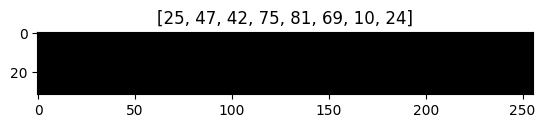

In [35]:
plt.ion()
imshow(out, title=[class_names[x] for x in classes[:8]])

In [36]:
from tensorflow import keras
from tensorflow.keras import layers

# 实例化 ResNet-18 模型
model = keras.applications.ResNet18(
    include_top=False, # 是否包含最后的全连接层
    weights="imagenet", # 使用 ImageNet 预训练的权重
    input_shape=(32, 32, 3), # 输入图像的形状
    pooling=None, # 特征提取时的池化方式
)

# 添加自定义的层
x = layers.GlobalAveragePooling2D()(model.output)
output = layers.Dense(len(class_names), activation="softmax")(x)
model = keras.Model(model.inputs, output)

# 编译模型
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=2e-4),
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=["accuracy"],
)

# 训练模型
model.fit(image_datasets['train'], epochs=25, validation_data=image_datasets['val'])

ValueError: invalid literal for int() with base 10: 'cifar-100-python'